In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, calculate, equilibrium, binplot
import pycalphad.variables as v
from binary_helpers import plot_convex_hull

# Load database and choose the phases that will be considered
dbf = Database('CrNb.TDB')
comps = ['CR', 'NB', 'VA']
phases = sorted(dbf.phases)

eq_alni = equilibrium(dbf, ['CR', 'NB', 'VA'], phases, {v.X('NB'): 0.5, v.T: (300, 2500, 20), v.P: 101325})


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


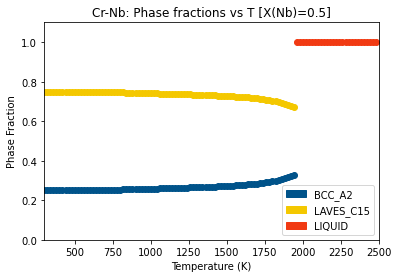

In [2]:
from pycalphad.plot.utils import phase_legend
phase_handles, phasemap = phase_legend(phases)

plt.gca().set_title('Cr-Nb: Phase fractions vs T [X(Nb)=0.5]')
plt.gca().set_xlabel('Temperature (K)')
plt.gca().set_ylabel('Phase Fraction')
plt.gca().set_ylim((0,1.1))
plt.gca().set_xlim((300, 2500))

for name in phases:
    phase_indices = np.nonzero(eq_alni.Phase.values == name)
    print(phase_indices[1])
    plt.scatter(np.take(eq_alni['T'].values, phase_indices[2]), eq_alni.NP.values[phase_indices], color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')

In [3]:
from pycalphad import Database, equilibrium, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt
import numpy as np

dbf = Database("CrNb.TDB")
comps = ["CR", "NB", "VA"]
phases = dbf.phases.keys()
print(phases)
# Create reference states
Cr_ref = ReferenceState("CR","BCC_A2", {v.T: 298.15, v.P: 101325})
Fe_ref = ReferenceState("NB", "BCC_A2", {v.T: 298.15, v.P: 101325})


dict_keys(['LIQUID', 'LAVES_C15', 'BCC_A2'])


In [8]:
# Create the models for each phase and shift them all by the same reference states.
eq_models = {}
for phase_name in phases:
    mod = Model(dbf, comps, phase_name)
    mod.shift_reference_state([Cr_ref, Fe_ref], dbf)
    eq_models[phase_name] = mod
print(eq_models)

{'LIQUID': <pycalphad.model.Model object at 0x7f4d559d6310>, 'LAVES_C15': <pycalphad.model.Model object at 0x7f4d559d61d0>, 'BCC_A2': <pycalphad.model.Model object at 0x7f4d55795cd0>}


In [11]:
# Calculate HMR at 2800 K from X(RE)=0 to X(RE)=1
conds = {v.P: 101325, v.T: 298.15, v.X("NB"): (0, 1, 0.01)}
result = equilibrium(dbf, comps, phases, conds, output="HMR", model=eq_models)
print(result)
# Find the groups of unique phases in equilibrium e.g. [CHI_RENB] and [CHI_RENB, HCP_RENB]
unique_phase_sets = np.unique(result.Phase.values.squeeze(), axis=0)
print(unique_phase_sets)

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_NB: 100, component: 2, internal_dof: 4, vertex: 3)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 298.1
  * X_NB       (X_NB) float64 1e-12 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99
  * vertex     (vertex) int64 0 1 2
  * component  (component) <U2 'CR' 'NB'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_NB, vertex) float64 nan nan nan ... 0.01499 0.985 nan
    GM         (N, P, T, X_NB) float64 nan -7.137e+03 ... -1.089e+04 -1.088e+04
    MU         (N, P, T, X_NB, component) float64 nan nan ... -1.088e+04
    X          (N, P, T, X_NB, vertex, component) float64 nan nan ... nan nan
    Y          (N, P, T, X_NB, vertex, internal_dof) float64 nan nan ... nan nan
    Phase      (N, P, T, X_NB, vertex) <U9 '' '' '' ... 'LAVES_C15' 'BCC_A2' ''
    HMR        (N, P, T, X_NB) float64 0.0 -83.86 -167.7 ... -83.65 -41.71
Attributes:
    

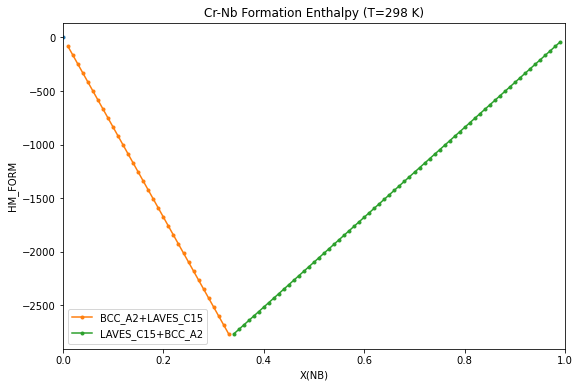

In [12]:
# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same unique phase
    unique_phase_idx = np.nonzero(np.all(result.Phase.values.squeeze() == phase_set, axis=1))[0]
    masked_result = result.isel(X_NB=unique_phase_idx)
    ax.plot(masked_result.X_NB.squeeze(), masked_result.HMR.squeeze(), marker='.', label=label)
ax.set_xlim((0, 1))
ax.set_xlabel('X(NB)')
ax.set_ylabel('HM_FORM')
ax.set_title('Cr-Nb Formation Enthalpy (T=298 K)')
ax.legend()
plt.show()

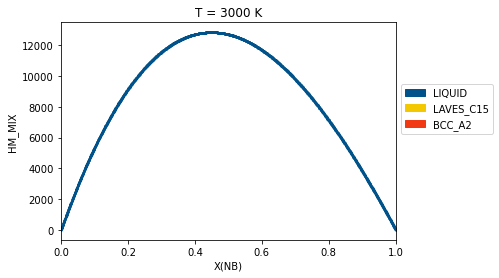

In [13]:
from pycalphad.plot.utils import phase_legend
import matplotlib.patches as mpatches

for T in [3000]:
    legend_handles, color_dict = phase_legend(phases)
    plt.figure()
    # Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(SN)
    phases=['LIQUID']
    for phase_name in phases:
        result = calculate(dbf, comps, phase_name, P=101325, T=T, N=1, output='HM_MIX')
        plt.scatter(result.X.sel(component='NB'), result.HM_MIX, marker='.', s=5, color=color_dict[phase_name], label=phase_name)

    # Format the plot
    plt.title(f'T = {T} K')
    plt.xlabel('X(NB)')
    plt.ylabel('HM_MIX')
    plt.xlim((0, 1))
    plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
    plt.show()

CPU times: user 23.7 s, sys: 346 ms, total: 24 s
Wall time: 24.3 s


<AxesSubplot:title={'center':'CR-NB'}, xlabel='X(NB)', ylabel='Temperature (K)'>

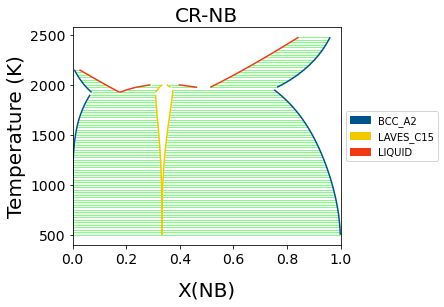

In [14]:
%%time
binplot(dbf, comps,  dbf.phases.keys(), {v.X('NB'): (0,1,0.01), v.T: (500, 2500, 25), v.P:101325, v.N: 1}, plot_kwargs={'scatter': False})